In [1]:
import sys
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time as time
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import colors
from netCDF4 import Dataset
from cartopy.io.img_tiles import GoogleTiles
from glob import glob
from scipy.interpolate import griddata
import os.path
from os import path
import requests
#
# Want to add conservative regridding, but cdo stuff isn't working.
#
#from cdo import *
#cdo = Cdo()

In [2]:
#
# User specified variables
#
archive_data_path = '/uufs/chpc.utah.edu/common/home/horel-group/archive'
ccyymmdd = '20191210'
hh = '00'
model = 'nam'
fhr = 84
region = 'NW'

In [3]:
#
# User defined functions for simple plotting to debug code
#
# Simple 2-d plot
#
def simple2dplot(a2darray):
    fig = plt.figure()
    plt.pcolormesh(a2darray)
    plt.show
#
# Simple histogram
#
def simplehisto(data):
    plt.hist(data.flatten())
    plt.show

In [4]:
#
# Class defines information for hillshade relief
#
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

In [5]:
#
# Point locations to plot on map
#
point_locs = {
    'KSLC':(40.77, -111.97), 'CLN':(40.57, -111.65),
    'MTMET':(40.766605, -111.828325), 'PCB':(40.65, -111.52),
    'CLK':(40.67, -111.57), 'PKCU1':(40.6, -111.57),
    'SNI':(41.2, -111.87), 'BLPU1':(41.38, -111.94),
    'TRLU1':(40.68, -110.95), 'DVO':(40.621, -111.496),
    'PWD':(41.37, -111.76), 'SND':(40.37, -111.6),
    'BSK':(45.27, -111.45), 'TOWC2':(40.55, -106.67),
    'CACMP':(40.52, -105.90), 'CABTP':(39.8, -105.77),
    'TUNEP':(39.67, -105.9), 'VAILP':(39.52, -106.22),
    'MONAP':(38.5, -106.32), 'CAMCP':(39.12, -107.27),
    'CARED':(37.9, -107.72), 'CAGMS':(39.05, -108.07),
    'CACBP':(37.7, -107.77), 'CAWCP':(37.47, -106.8),
    'CUMC2':(37.02, -106.45), 'SNO':(47.42, -121.41),
    'KC07':(40.46, -106.76), 'KSBS':(40.48, -106.82),
    'KASE':(39.22, -106.78), 'KGJT':(39.12, -108.53),
    'KGUC':(38.55, -106.92), 'KTEX':(37.95, -107.91),
    'KDRO':(37.16, -107.75), 'WEP':(38.73, -107.20),
    'MTC':(37.87, -109.34), 'ABAUT':(37.84107, -109.46188),
    'CSSL':(39.33, -120.37), 'TGLU1':(41.90, -111.57),
    'SRAC1':(38.32, -119.60), 'SEE':(39.312, -111.429),
    'MSA':(37.65, -119.04), 'MTB':(48.86, -121.68),
    'STV':(47.75, -121.09), 'CMT':(46.93, -121.47),
    'PRS':(46.79, -121.74), 'QUI':(47.47, -123.85),
    'TIM':(45.33, -121.71), 'MBB':(44.0, -121.66),
    'MSB':(41.36, -122.20), 'SQV':(39.2, -120.24),
    'TTSID':(43.86,-114.71), 'JHRV':(43.59, -110.87),
    'LSMU1':(38.48,-109.27),
    'WDYPK':(40.84148,-111.02062), 'PCCAT':(40.7904494,-111.1053804),
    'STORM':(40.455111, -106.74428), 'SVSID':(43.6612, -114.4121),
    'ASBTP':(35.32581, -111.68559), 'MBNCA':(34.274425, -117.610439),
    'BBEAR':(34.212482, -116.867175), 'TAONM':(36.57443, -105.45328),
    'BASI1':(44.306003, -115.231829), 'LPSI1':(46.63448, -114.58072),
    'BKSI1':(44.62642, -115.79370), 'BIGMS':(48.502483, -114.342139),
    'NOIM8':(48.15678, -113.94637), 'TURMT':(48.3250, -113.6923),
    'LMLN2':(40.64480, -115.38120), 'WAP55':(48.52578, -120.65525),
    'TUM42':(47.62833, -120.70717), 'SASW1':(47.38485, -121.06323),
    'CBS':(38.887, -106.948)
    }

In [6]:
#
# Map regions
#
map_regions = {
    'UT':(-114.7, -108.5, 36.7, 42.5),
    'WM':(-117, -108.5, 43, 49),
    'CO':(-110, -104, 36, 41.9),
    'SJ':(-109.0, -107.0, 37, 38.5),
    'SN':(-123.5, -116.0, 33.5, 41),
    'LT':(-121.5,-119.25,38.0,40.0),
    'WE':(-125, -102.5, 31.0, 49.2),
    'NW':(-125, -116.5, 42.0, 49.1),
    'SP':(-122.5,-120.5,46.4,48.4),
    'NU':(-113.4, -110.7, 39.5, 41.9),
    'WR':(-112.35, -111.05, 40.2, 41.5)
    }

In [7]:
#
# Accumulation period should be 24 to match nohrsc
#
accumperiod = 24
#
# Define left longitude, right longitude, bottom latitude, top latitude, center longitude, center latitude, and the hill-shade detail (bigger 
# number means more detail) for plan-view maps
#
left_longitude, right_longitude, bottom_latitude, top_latitude = map_regions[region]
centlon = (left_longitude + right_longitude)/2
centlat = (bottom_latitude + top_latitude)/2
hill_shade_detail = int(np.maximum(10/((top_latitude-bottom_latitude)**.5),5))

In [8]:
#
# Open model data files
#
model_file_string = archive_data_path+'/'+ccyymmdd+'/models/'+model+'ds/'+ccyymmdd+hh+'/'
model_file_list = glob(model_file_string + '*.nc')
model_file_list = np.array(model_file_list)[np.argsort(model_file_list)]
model_data = xr.open_mfdataset(model_file_list, combine='by_coords')

In [9]:
#
# Extract latitude and longitude and put into 2D array
# 
model_latitude_tmp = model_data.lat.values
model_longitude_tmp = model_data.lon.values
left_longitude_index=min(range(len(model_longitude_tmp)), key=lambda i: abs(model_longitude_tmp[i]-left_longitude))
right_longitude_index=min(range(len(model_longitude_tmp)), key=lambda i: abs(model_longitude_tmp[i]-right_longitude))
bottom_latitude_index=min(range(len(model_latitude_tmp)), key=lambda i: abs(model_latitude_tmp[i]-bottom_latitude))
top_latitude_index=min(range(len(model_latitude_tmp)), key=lambda i: abs(model_latitude_tmp[i]-top_latitude))
model_longitude, model_latitude = np.meshgrid(model_longitude_tmp[left_longitude_index:right_longitude_index],model_latitude_tmp[bottom_latitude_index:top_latitude_index])
#
# Determine end and start times of the accumulation period
#
accumend = int(fhr/3+1)
accumstart = int(accumend-accumperiod/3)
accumendtime = datetime.strftime(pd.to_datetime(model_data.time.values[accumend-1]),'%Y-%m-%d %H:%M UTC')
accumstarttime = datetime.strftime(pd.to_datetime(model_data.time.values[accumstart-1]),'%Y-%m-%d %H:%M UTC')
#
# Output to screen
#
print ('plotting',accumperiod,'hr accumulation beginning',accumstarttime,'ending ',accumendtime)
print ('Involves summing 3-h accumulations for periods ending below')
print (model_data.dqsf.isel(time=slice(accumstart,accumend)).time.values)
#
# Extract downscaled snowfall, undownscaled snowfall, and downscaled qpf for the accmulation period and convert to inches
#
model_dqsf = model_data.dqsf.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).sum(dim="time").values/25.4
model_dqsf_units='inches'
model_qsf = model_data.qsf.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).sum(dim="time").values/25.4
model_qsf_units='inches'
model_dqpf = model_data.qsf.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).sum(dim="time").values/254
model_dqpf_units='inches'
model_max_wbzh = model_data.wbzh.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).max(dim="time").values
model_min_wbzh = model_data.wbzh.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(bottom_latitude_index,top_latitude_index),time=slice(accumstart,accumend)).min(dim="time").values
model_wbzh_units='meters'
#
# Calculate the mean SLR based on the downscaled qpf and qsf where snowfall > 0.5 inches  
#
model_mean_slr = xr.where(model_dqsf >= 0.5, model_dqsf/model_dqpf, np.nan)

plotting 24 hr accumulation beginning 2019-12-12 12:00 UTC ending  2019-12-13 12:00 UTC
Involves summing 3-h accumulations for periods ending below
['2019-12-12T15:00:00.000000000' '2019-12-12T18:00:00.000000000'
 '2019-12-12T21:00:00.000000000' '2019-12-13T00:00:00.000000000'
 '2019-12-13T03:00:00.000000000' '2019-12-13T06:00:00.000000000'
 '2019-12-13T09:00:00.000000000' '2019-12-13T12:00:00.000000000']


/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [10]:
#
# Determine the corresponding date and name for the NOHRSC data and file, respectively
# Stop if validation time does not equate to 0000 or 1200 UTC
#
ccyymmddhh = ccyymmdd+hh
validtime = (datetime.strptime(ccyymmddhh, "%Y%m%d%H") + timedelta(hours=fhr)).strftime("%Y%m%d%H")
if validtime[-2:] != '00' and validtime[-2:] != '12':
    raise(ValueError('Validation time',validtime,'does not equal 00 or 12 UTC, exiting'))
nohrsc_file = './sfav2_CONUS_24h_'+validtime+'.nc'
try:
    nohrsc_data = xr.open_dataset(nohrsc_file)
except:
    print('nohrsc file',nohrsc_file,'not found, trying to download')
    url = 'https://www.nohrsc.noaa.gov/snowfall/data/'+str(validtime[:6])+'/sfav2_CONUS_24h_'+validtime+'.nc'
    r=requests.get(url, allow_redirects=True)
    open('sfav2_CONUS_24h_'+validtime+'.nc','wb').write(r.content)
    try:
        print('trying to read file')
        nohrsc_data = xr.open_dataset(nohrsc_file)
    except:
        raise(ValueError('nohrsc data',nohrsc_file,'not available'))
#
# Extract latitude and longitude and put into 2D array
#
print('NOHRSC data found for',validtime)
nohrsc_latitude_tmp = nohrsc_data.lat.values
nohrsc_longitude_tmp = nohrsc_data.lon.values
left_longitude_index=min(range(len(nohrsc_longitude_tmp)), key=lambda i: abs(nohrsc_longitude_tmp[i]-left_longitude))-2
right_longitude_index=min(range(len(nohrsc_longitude_tmp)), key=lambda i: abs(nohrsc_longitude_tmp[i]-right_longitude))+2
bottom_latitude_index=min(range(len(nohrsc_latitude_tmp)), key=lambda i: abs(nohrsc_latitude_tmp[i]-bottom_latitude))+2
top_latitude_index=min(range(len(nohrsc_latitude_tmp)), key=lambda i: abs(nohrsc_latitude_tmp[i]-top_latitude))-2
#
# Latitude decreases with increasing index, so swapping top_latitude_index and bottom_latitude_index order for slice below
#
nohrsc_longitude, nohrsc_latitude = np.meshgrid(nohrsc_longitude_tmp[left_longitude_index:right_longitude_index],nohrsc_latitude_tmp[top_latitude_index:bottom_latitude_index])
#
# Extract analyzed snowfall (dataset unit is meters), convert to inches
#
nohrsc_snow = nohrsc_data.Data.isel(lon=slice(left_longitude_index,right_longitude_index),lat=slice(top_latitude_index,bottom_latitude_index))*39.37
nohrsc_snow_units='inches'

NOHRSC data found for 2019121312


In [11]:
#
#  Regrid nohrsc data to model grid 
#
nohrsc_snow_on_model_grid = griddata(
    (nohrsc_latitude.flatten(), nohrsc_longitude.flatten()), # input lat lons as 1d arrays
    nohrsc_snow.values.flatten(), # input 2d array of data, flattened
    (model_latitude, model_longitude),
    method='linear')
#
#  Regrid downscaled model forecast to nohrsc grid
#
model_dqsf_on_nohrsc_grid = griddata(
    (model_latitude.flatten(), model_longitude.flatten()), # input lat lons as 1d arrays
    model_dqsf.flatten(), # input 2d array of data, flattened
    (nohrsc_latitude, nohrsc_longitude),
    method='linear')
#
#  Calculate model bias on nohrsc grid
#
dqsf_bias = model_dqsf_on_nohrsc_grid - nohrsc_snow

In [12]:
#
# Open 30-sec terrain file
#
dem_data = xr.open_dataset('/uufs/chpc.utah.edu/sys/pkg/ldm/oper/models/downscaledqsf/prism/usterrain.nc')
#
# Extract latitude and longitude and put into 2D array
#
dem_latitude_tmp = dem_data.latitude.values
dem_longitude_tmp = dem_data.longitude.values
left_longitude_index=min(range(len(dem_longitude_tmp)), key=lambda i: abs(dem_longitude_tmp[i]-left_longitude))-20
right_longitude_index=min(range(len(dem_longitude_tmp)), key=lambda i: abs(dem_longitude_tmp[i]-right_longitude))+20
bottom_latitude_index=min(range(len(dem_latitude_tmp)), key=lambda i: abs(dem_latitude_tmp[i]-bottom_latitude))-20
top_latitude_index=min(range(len(dem_latitude_tmp)), key=lambda i: abs(dem_latitude_tmp[i]-top_latitude))+20
dem_longitude, dem_latitude = np.meshgrid(dem_longitude_tmp[left_longitude_index:right_longitude_index],dem_latitude_tmp[bottom_latitude_index:top_latitude_index])
dem = dem_data.elevation.isel(longitude=slice(left_longitude_index,right_longitude_index),latitude=slice(bottom_latitude_index,top_latitude_index))
#
# Regrid terrain onto model grid
#
dem_on_model_grid = griddata(
    (dem_latitude.flatten(), dem_longitude.flatten()), # input lat lons as 1d arrays
    dem.values.flatten(), # input 2d array of data, flattened
    (model_latitude, model_longitude),
    method='linear')
#
# Regrid terrain onto nohrsc grid
#
dem_on_nohrsc_grid = griddata(
    (dem_latitude.flatten(), dem_longitude.flatten()), # input lat lons as 1d arrays
    dem.values.flatten(), # input 2d array of data, flattened
    (nohrsc_latitude, nohrsc_longitude),
    method='linear')

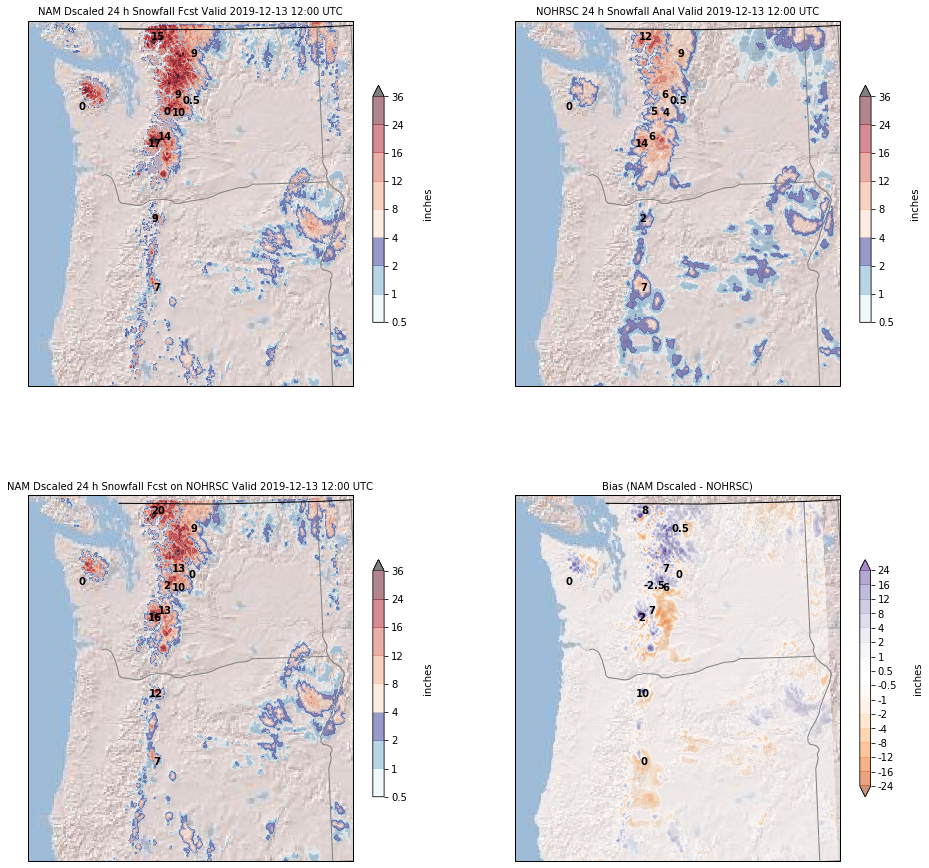

In [13]:
#
#  Four panel (2x2) plan-view plots
#
# Set figure size and projection information
#
plt.rcParams['figure.figsize'] = (16,16)
proj = ccrs.LambertConformal(central_longitude=centlon,central_latitude=centlat, standard_parallels=[40])
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj))
#
#  Upper-left plot (axes[0,0]) ----------------------------------------------------------------------------------------
#
# Define color fill levels and colors
#
snow_color_fill_levels = ([0.5,1,2,4,8,12,16,24,36])
snow_fill_colors = ['#E0F3F8',
               '#73ADD1',
               '#323696',
               '#FDDBC7',
               '#F4a582',
               '#D6614E',
               '#B1182B',
               '#670A1F',
               'black']
snow_color_map = colors.ListedColormap(snow_fill_colors[:-1], name='snowmap')
snow_color_map.set_over(snow_fill_colors[-1])
snow_vmin, snow_vmax = snow_color_fill_levels[0], snow_color_fill_levels[-1]
snow_norml = colors.BoundaryNorm(snow_color_fill_levels, len(snow_fill_colors)-1)
#
# Define where to draw ticks for color bar
#
color_bar_ticks = [str(x) for x in snow_color_fill_levels]
#
#  Define region (left lon, right lon, bottom lat, top lat)
#
axes[0,0].set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])
#
#  Shaded relief, state borders
#
axes[0,0].add_image(ShadedReliefESRI(), hill_shade_detail)
axes[0,0].add_feature(cfeature.BORDERS, zorder=10)
axes[0,0].add_feature(states_provinces, edgecolor='gray', zorder=10)
#
# Model dqsf as color filled contour plot
#
snow_fill = axes[0,0].contourf(model_longitude,
                         model_latitude,
                         model_dqsf,
                         levels=snow_color_fill_levels, 
                         vmin=snow_vmin, 
                         vmax=snow_vmax, 
                         norm=snow_norml, 
                         extend='max', 
                         alpha=0.5,
                         cmap=snow_color_map,
                         zorder=2,
                         transform=ccrs.PlateCarree())
if top_latitude - bottom_latitude < 2.5 and right_longitude - left_longitude < 2.5:
    axes[0,0].contour(model_longitude,
                model_latitude,
                model_dqsf,
                levels=snow_color_fill_levels, 
                alpha=1,
                linewidths=0.7,
                colors='gray',
                transform=ccrs.PlateCarree())
#
# Add values at point locations
#
for site in point_locs:
    point_latitude, point_longitude = point_locs[site]
    if point_latitude > bottom_latitude and point_latitude < top_latitude and point_longitude > left_longitude and point_longitude < right_longitude:
        coordinates=np.unravel_index((np.abs(model_latitude-point_latitude)+np.abs(model_longitude-point_longitude)).argmin(),model_latitude.shape)
        point_loc_value=int(model_dqsf[coordinates[0],coordinates[1]]*2.)/2.
        if point_loc_value >= 1.0:
            point_loc_value=int(point_loc_value)
        elif point_loc_value == 0.0:
            point_loc_value=int(point_loc_value)
        axes[0,0].text(point_longitude,point_latitude, str(point_loc_value),
            horizontalalignment='center',verticalalignment='center',color='black',weight='bold',size='10',
            transform=ccrs.PlateCarree())
#
# Plot colorbar
#
colorbar = plt.colorbar(snow_fill,shrink=.6,label='\n'+model_dqsf_units,ax=axes[0,0])
colorbar.set_ticks(snow_color_fill_levels)
colorbar.set_ticklabels(color_bar_ticks)
#
# Plot title
#
title = '%s Dscaled %s h Snowfall Fcst Valid %s'%(model.upper(),accumperiod,accumendtime)
axes[0,0].set_title(title,fontsize=10)
#
#  Upper-right plot (axes[0,1]) ----------------------------------------------------------------------------------------
#
#  Define region (left lon, right lon, bottom lat, top lat)
#
axes[0,1].set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])
#
#  Shaded relief, state borders
#
axes[0,1].add_image(ShadedReliefESRI(), hill_shade_detail)
axes[0,1].add_feature(cfeature.BORDERS, zorder=10)
axes[0,1].add_feature(states_provinces, edgecolor='gray', zorder=10)
#
# nohrsc analyzed snowfall as color filled contour plot
#
snow_fill = axes[0,1].contourf(nohrsc_longitude,
                         nohrsc_latitude,
                         nohrsc_snow,
                         levels=snow_color_fill_levels, 
                         vmin=snow_vmin, 
                         vmax=snow_vmax, 
                         norm=snow_norml, 
                         extend='max', 
                         alpha=0.5,
                         cmap=snow_color_map,
                         zorder=2,
                         transform=ccrs.PlateCarree())
if top_latitude - bottom_latitude < 2.5 and right_longitude - left_longitude < 2.5:
    axes[0,1].contour(nohrsc_longitude,
                nohrsc_latitude,
                nohrsc_snow,
                levels=snow_color_fill_levels, 
                alpha=1,
                linewidths=0.7,
                colors='gray',
                transform=ccrs.PlateCarree())
for site in point_locs:
    point_latitude, point_longitude = point_locs[site]
    if point_latitude > bottom_latitude and point_latitude < top_latitude and point_longitude > left_longitude and point_longitude < right_longitude:
        coordinates=np.unravel_index((np.abs(nohrsc_latitude-point_latitude)+np.abs(nohrsc_longitude-point_longitude)).argmin(),nohrsc_latitude.shape)
        point_loc_value=int(nohrsc_snow[coordinates[0],coordinates[1]]*2.)/2.
        if point_loc_value >= 1.0:
            point_loc_value=int(point_loc_value)
        elif point_loc_value == 0.0:
            point_loc_value=int(point_loc_value)
        axes[0,1].text(point_longitude,point_latitude, str(point_loc_value),
            horizontalalignment='center',verticalalignment='center',color='black',weight='bold',size='10',
            transform=ccrs.PlateCarree())
#
# Plot colorbar
#
colorbar = plt.colorbar(snow_fill,shrink=.6,label='\n'+nohrsc_snow_units,ax=axes[0,1])
colorbar.set_ticks(snow_color_fill_levels)
colorbar.set_ticklabels(color_bar_ticks)
#
# Plot title
#
title = 'NOHRSC %s h Snowfall Anal Valid %s'%(accumperiod,accumendtime)
axes[0,1].set_title(title,fontsize=10)
#
#  Lower-left plot (axes[1,0]) ----------------------------------------------------------------------------------------
#
#  Define region (left lon, right lon, bottom lat, top lat)
#
axes[1,0].set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])
#
#  Shaded relief, state borders
#
axes[1,0].add_image(ShadedReliefESRI(), hill_shade_detail)
axes[1,0].add_feature(cfeature.BORDERS, zorder=10)
axes[1,0].add_feature(states_provinces, edgecolor='gray', zorder=10)
#
# model snowfall on nohrsc grid
#
snow_fill = axes[1,0].contourf(nohrsc_longitude,
                         nohrsc_latitude,
                         model_dqsf_on_nohrsc_grid,
                         levels=snow_color_fill_levels, 
                         vmin=snow_vmin, 
                         vmax=snow_vmax, 
                         norm=snow_norml, 
                         extend='max', 
                         alpha=0.5,
                         cmap=snow_color_map,
                         zorder=2,
                         transform=ccrs.PlateCarree())
if top_latitude - bottom_latitude < 2.5 and right_longitude - left_longitude < 2.5:
    axes[1,0].contour(nohrsc_longitude,
                nohrsc_latitude,
                model_dqsf_on_nohrsc_grid,
                levels=snow_color_fill_levels, 
                alpha=1,
                linewidths=0.7,
                colors='gray',
                transform=ccrs.PlateCarree())
for site in point_locs:
    point_latitude, point_longitude = point_locs[site]
    if point_latitude > bottom_latitude and point_latitude < top_latitude and point_longitude > left_longitude and point_longitude < right_longitude:
        coordinates=np.unravel_index((np.abs(nohrsc_latitude-point_latitude)+np.abs(nohrsc_longitude-point_longitude)).argmin(),nohrsc_latitude.shape)
        point_loc_value=int(model_dqsf_on_nohrsc_grid[coordinates[0],coordinates[1]]*2.)/2.
        if point_loc_value >= 1.0:
            point_loc_value=int(point_loc_value)
        elif point_loc_value == 0.0:
            point_loc_value=int(point_loc_value)
        axes[1,0].text(point_longitude,point_latitude, str(point_loc_value),
            horizontalalignment='center',verticalalignment='center',color='black',weight='bold',size='10',
            transform=ccrs.PlateCarree())
#
# Plot colorbar
#
colorbar = plt.colorbar(snow_fill,shrink=.6,label='\n'+nohrsc_snow_units,ax=axes[1,0])
colorbar.set_ticks(snow_color_fill_levels)
colorbar.set_ticklabels(color_bar_ticks)
#
# Plot title
#
title = '%s Dscaled %s h Snowfall Fcst on NOHRSC Valid %s'%(model.upper(),accumperiod,accumendtime)
axes[1,0].set_title(title,fontsize=10)
#
#  Lower Right Plot (axes[1,1]) ----------------------------------------------------------------------------------------
#
#  Define region (left lon, right lon, bottom lat, top lat)
#
axes[1,1].set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])
#
#  Shaded relief, state borders
#
axes[1,1].add_image(ShadedReliefESRI(), hill_shade_detail)
axes[1,1].add_feature(cfeature.BORDERS, zorder=10)
axes[1,1].add_feature(states_provinces, edgecolor='gray', zorder=10)
#
# Model bias as color filled contour plot
#
bias_color_fill_levels =([-24,-16,-12,-8,-4,-2,-1,-0.5,0.5,1,2,4,8,12,16,24])
bias_fill_colors = ['#d94801',
               '#f16913',
               '#fd8d3c',
               '#fdae6b',
               '#fdd0a2',
               '#fee6ce',
               '#fff5eb',
               'white',
               '#fcfbfd',
               '#efedf5',
               '#dadaeb',
               '#bcbddc',
               '#9e9ac8',
               '#807dba',
               '#6a51a3',
               '#4a1486']
bias_color_map = colors.ListedColormap(bias_fill_colors, name='biasmap')
bias_color_map.set_under('#8c2d04')
bias_vmin, bias_vmax = bias_color_fill_levels[0], bias_color_fill_levels[-1]
bias_norml = colors.BoundaryNorm(bias_color_fill_levels, len(bias_fill_colors)-1)
#
# Define where to draw ticks for color bar
#
bias_color_bar_ticks = [str(x) for x in bias_color_fill_levels]
bias_fill = axes[1,1].contourf(nohrsc_longitude,
                         nohrsc_latitude,
                         dqsf_bias,
                         levels=bias_color_fill_levels, 
                         vmin=bias_vmin, 
                         vmax=bias_vmax, 
                         norm=bias_norml,
                         extend='both',
                         alpha=0.5,
                         cmap=bias_color_map,
                         zorder=2,
                         transform=ccrs.PlateCarree())
#
# Make negative contours solid not dashed
#
if top_latitude - bottom_latitude < 2.5 and right_longitude - left_longitude < 2.5:
    plt.rcParams['contour.negative_linestyle'] = 'solid'
    axes[1,1].contour(nohrsc_longitude,
                nohrsc_latitude,
                dqsf_bias,
                levels=bias_color_fill_levels, 
                alpha=1,
                linewidths=0.7,
                colors='gray',
                transform=ccrs.PlateCarree())
#
# Add values at point locations
#
for site in point_locs:
    point_latitude, point_longitude = point_locs[site]
    if point_latitude > bottom_latitude and point_latitude < top_latitude and point_longitude > left_longitude and point_longitude < right_longitude:
        coordinates=np.unravel_index((np.abs(nohrsc_latitude-point_latitude)+np.abs(nohrsc_longitude-point_longitude)).argmin(),nohrsc_latitude.shape)
        point_loc_value=int(dqsf_bias[coordinates[0],coordinates[1]]*2.)/2.
        if point_loc_value >= 1.0:
            point_loc_value=int(point_loc_value)
        elif point_loc_value == 0.0:
            point_loc_value=int(point_loc_value)
        axes[1,1].text(point_longitude,point_latitude, str(point_loc_value),
            horizontalalignment='center',verticalalignment='center',color='black',weight='bold',size='10',
            transform=ccrs.PlateCarree())
#
# Plot colorbar
#
colorbar = plt.colorbar(bias_fill,shrink=.6,label='\n'+model_dqsf_units,ax=axes[1,1])
colorbar.set_ticks(bias_color_fill_levels)
colorbar.set_ticklabels(bias_color_bar_ticks)
#
# Plot title
#
title = 'Bias (NAM Dscaled - NOHRSC)'
axes[1,1].set_title(title,fontsize=10)
#plt.show()
gfile = 'planview_%s.png'%(region)
plt.savefig(gfile, bbox_inches='tight')

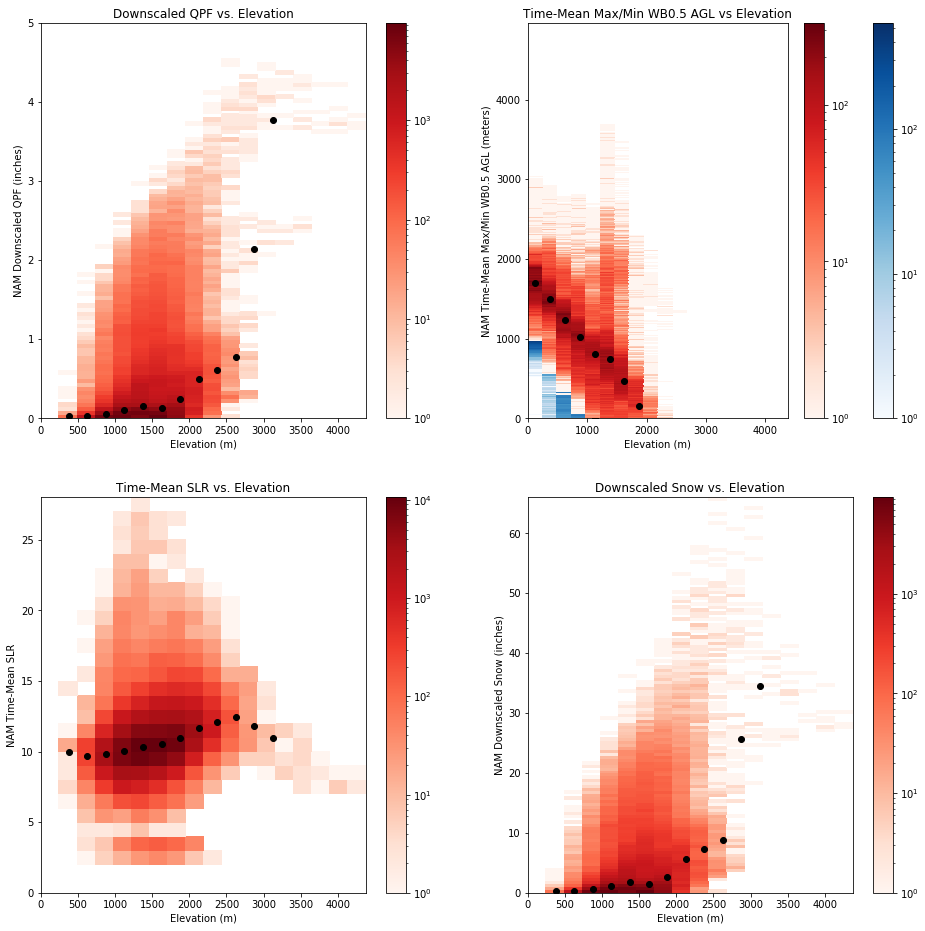

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
#
# Upper Left Plot (axes[0,0]) ----------------------------------------------------------------------------------------
#
# Find range for elevation and model_mean_slr  
# Set bins for model_mean_slr to 
#
max_x=np.nanmax(dem_on_model_grid)+100
min_x=np.maximum(np.nanmin(dem_on_model_grid)-100,-100)
xbin = max_x/250+1
max_y=np.trunc(np.nanmax(model_dqpf))+1
min_y=0
ybin = max_y*20
#
# Plot 2D histogram
#
h = axes[0,0].hist2d(dem_on_model_grid.flatten(), np.where((model_dqpf.flatten() < 0.01), np.nan, model_dqpf.flatten()),bins=(xbin,ybin), range=[[0,max_x],[0,max_y]], cmap=plt.cm.Reds, norm=mpl.colors.LogNorm())
plt.colorbar(h[3], ax=axes[0,0])
#
# Plot medians in each elevation bin
#
for elev in np.arange (0, max_x, 250):
    stuff = np.where((dem_on_model_grid.flatten() > elev) & (dem_on_model_grid.flatten() < elev + 250), np.where((model_dqpf.flatten() < 0.01), np.nan, model_dqpf.flatten()), np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(abs(stuff))
        axes[0,0].scatter (elev + 125, median, marker='o', c='black')
title = 'Downscaled QPF vs. Elevation'
axes[0,0].set_title(title)
axes[0,0].set_xlabel('Elevation (m)')
ylabel = '%s Downscaled QPF (inches)'%(model.upper())
axes[0,0].set_ylabel(ylabel)
#
# Upper Right Plot (axes[0,1]) ----------------------------------------------------------------------------------------
#
# Find range for elevation and model_mean_slr  
# Set bins for model_mean_slr to 
#
max_y=int(np.nanmax(abs(model_max_wbzh)))+1
min_y=0
ybin = max_y
#
# Plot 2D histograms of minimum and maximum wbzh AGL *if* there are values AGL
#
if np.nanmax(model_min_wbzh - dem_on_model_grid) > 0:
    h = axes[0,1].hist2d(dem_on_model_grid.flatten(), model_min_wbzh.flatten() - dem_on_model_grid.flatten(),bins=(xbin,ybin), range=[[0,max_x],[0,max_y]], cmap=plt.cm.Blues, norm=mpl.colors.LogNorm())
    plt.colorbar(h[3], ax=axes[0,1])
    for elev in np.arange (0, max_x, 250):
        stuff = np.where((dem_on_model_grid.flatten() > elev) & (dem_on_model_grid.flatten() < elev + 250), model_min_wbzh.flatten() - dem_on_model_grid.flatten(), np.nan)
        non_nans = len(stuff) - np.isnan(stuff).sum()
        if non_nans >= 20:
            median = np.nanmedian(stuff)
            if median >= 0:
                axes[0,1].scatter (elev + 125, median, marker='s', c='black')
if np.nanmax(model_max_wbzh - dem_on_model_grid) > 0:
    h = axes[0,1].hist2d(dem_on_model_grid.flatten(), model_max_wbzh.flatten() - dem_on_model_grid.flatten(),bins=(xbin,ybin), range=[[0,max_x],[0,max_y]], cmap=plt.cm.Reds, norm=mpl.colors.LogNorm())
    plt.colorbar(h[3], ax=axes[0,1])
    for elev in np.arange (0, max_x, 250):
        stuff = np.where((dem_on_model_grid.flatten() > elev) & (dem_on_model_grid.flatten() < elev + 250), model_max_wbzh.flatten() - dem_on_model_grid.flatten(), np.nan)
        non_nans = len(stuff) - np.isnan(stuff).sum()
        if non_nans >= 20:
            median = np.nanmedian(stuff)
            if median >= 0:
                axes[0,1].scatter (elev + 125, median, marker='o', c='black')
    title = 'Time-Mean Max/Min WB0.5 AGL vs Elevation'
    axes[0,1].set_title(title)
    axes[0,1].set_xlabel('Elevation (m)')
    ylabel = '%s Time-Mean Max/Min WB0.5 AGL (meters)'%(model.upper())
    axes[0,1].set_ylabel(ylabel)
else:
    axes[0,1].text(.5,.5,'Min and Max WB0.5 Below Ground Throughout Domain',horizontalalignment='center')
#
# Lower Left Plot (axes[1,0]) ----------------------------------------------------------------------------------------
#
# Find range for elevation and model_mean_slr  
# Set bins for model_mean_slr to 
#
max_y=int(np.nanmax(abs(model_mean_slr)))+1
min_y=0
ybin = max_y
#
# Plot 2D histogram
#
h = axes[1,0].hist2d(dem_on_model_grid.flatten(), model_mean_slr.flatten(),bins=(xbin,ybin), range=[[0,max_x],[0,max_y]], cmap=plt.cm.Reds, norm=mpl.colors.LogNorm())
plt.colorbar(h[3], ax=axes[1,0])
#
# Plot medians in each elevation bin
#
for elev in np.arange (0, max_x, 250):
    stuff = np.where((dem_on_model_grid.flatten() > elev) & (dem_on_model_grid.flatten() < elev + 250), model_mean_slr.flatten(), np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(abs(stuff))
        axes[1,0].scatter (elev + 125, median, marker='o', c='black')
title = 'Time-Mean SLR vs. Elevation'
axes[1,0].set_title(title)
axes[1,0].set_xlabel('Elevation (m)')
ylabel = '%s Time-Mean SLR'%(model.upper())
axes[1,0].set_ylabel(ylabel)
#
# Lower Right Plot (axes[1,1]) ----------------------------------------------------------------------------------------
#
# Find range for elevation and model_mean_slr  
# Set bins for model_mean_slr to 
#
max_y=int(np.nanmax(abs(model_dqsf)))+1
min_y=0
ybin = max_y*2
#
# Plot 2D histogram
#
h = axes[1,1].hist2d(dem_on_model_grid.flatten(), np.where((model_dqsf.flatten() < 0.1), np.nan, model_dqsf.flatten()),bins=(xbin,ybin), range=[[0,max_x],[0,max_y]], cmap=plt.cm.Reds, norm=mpl.colors.LogNorm())
plt.colorbar(h[3], ax=axes[1,1])
#
# Plot medians in each elevation bin
#
for elev in np.arange (0, max_x, 250):
    stuff = np.where((dem_on_model_grid.flatten() > elev) & (dem_on_model_grid.flatten() < elev + 250), np.where((model_dqsf.flatten() < 0.1), np.nan, model_dqsf.flatten()), np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(abs(stuff))
        axes[1,1].scatter (elev + 125, median, marker='o', c='black')
title = 'Downscaled Snow vs. Elevation'
axes[1,1].set_title(title)
axes[1,1].set_xlabel('Elevation (m)')
ylabel = '%s Downscaled Snow (inches)'%(model.upper())
axes[1,1].set_ylabel(ylabel)
#plt.show()
gfile = 'Hist1_%s.png'%(region)
plt.savefig(gfile, bbox_inches='tight')

In [15]:
#
# User defined functions for 2d Histogram Plots
#
# notraces replaces values where both model_dqsf 
# and nohrsc snow are below 0.5 with nan and flattens
# array to 1D
#
def notraces(data):
    return np.where((model_dqsf_on_nohrsc_grid.flatten() < 0.5) & (nohrsc_snow.values.flatten() < 0.5), np.nan, data.flatten())

/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less
/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/common/home/u0028395/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less


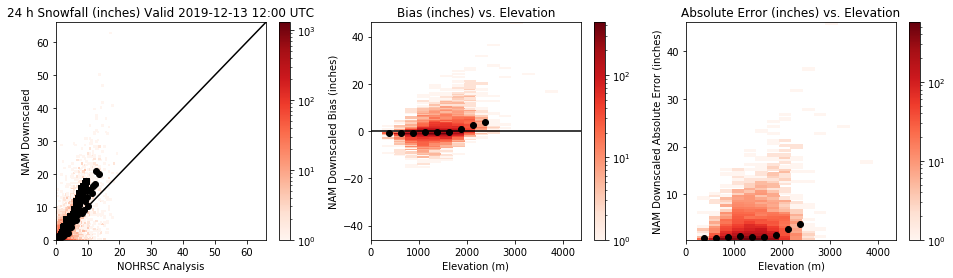

In [16]:
#
# Set figure size and four panel layout
#
fig, axes = plt.subplots(1, 3, figsize=(16,4))
#
# Create new arrays (flattened to 1d) with nan where 
# both model_dqsf and nohrsc have < 0.5 inches of snow
#
model_dqsf_notraces = notraces(model_dqsf_on_nohrsc_grid)
nohrsc_snow_notraces = notraces(nohrsc_snow.values)
dqsf_bias_notraces = notraces(dqsf_bias.values)
#
# Left Plot (axes[0]) -----------------------------------------
# Two-dimensional histogram of model downscaled snow vs. NOHRSC analysis
#
# Range for 2dhistogram to max_value, which is the highest value
# of either model downscaled snow or NOHRSC analysis
#
# Bin size set to 0.5 inches
#
max_value=int(np.maximum(np.nanmax(model_dqsf),np.nanmax(nohrsc_snow))+1)
bin = max_value*2
#
# Plot histogram and color bar
#
h = axes[0].hist2d(nohrsc_snow_notraces, 
                     model_dqsf_notraces,
                     bins=(bin,bin), 
                     range=[[0,max_value],[0,max_value]], 
                     cmap=plt.cm.Reds, 
                     norm=mpl.colors.LogNorm())
plt.colorbar(h[3], ax=axes[0])
#
# Add 1:1 line, title, and axis lables
#
xy_line = np.arange(0, max_value+1)
axes[0].plot(xy_line,xy_line, 'black')
title = '%s h Snowfall (inches) Valid %s'%(accumperiod,accumendtime)
axes[0].set_title(title)
axes[0].set_xlabel('NOHRSC Analysis')
ylabel = '%s Downscaled'%(model.upper())
axes[0].set_ylabel(ylabel)
#
# Add model_dqsf medians as circles
# Again, not considering points where both 
# model_dqsf and nohrsc are both < 0.5 inches
#
for x in np.arange (.5, max_value, .5):
    stuff = np.where((nohrsc_snow_notraces > x) & (nohrsc_snow_notraces < x + .5), model_dqsf_notraces, np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(stuff)
        axes[0].scatter (x+.25, median, marker='o', c='black')
#
# Add nohrsc medians as squares
# jim-to-do: Should model_dqsf.flatten() below be model_dqsf_notraces.flatten or doesn't it matter?
#
for x in np.arange (.5, max_value, .5):
    stuff = np.where((model_dqsf_on_nohrsc_grid.flatten() > x) & (model_dqsf_on_nohrsc_grid.flatten() < x + .5), nohrsc_snow_notraces, np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(stuff)
        axes[0].scatter (median, x+.25, marker='s', c='black')
#
# Center Plot (axes[1]) ----------------------------------------------------------------------------------------
# Two-dimensional histogram of model downscaled snow bias vs. Elevation
# Again, not considering points where both 
# model_dqsf and nohrsc are both < 0.5 inches
#
# Find range for elevation and bias.  
# Set bins for bias to half an inch
#
max_dem=np.nanmax(dem_on_model_grid)+100
min_dem=np.maximum(np.nanmin(dem_on_model_grid)-100,-100)
xbin = max_dem/250+1
max_bias=int(np.nanmax(abs(dqsf_bias.values)))+1
min_bias=max_bias*(-1)
ybin = (max_bias-min_bias)*2
#
# Plot histogram and color bar
#
h = axes[1].hist2d(dem_on_nohrsc_grid.flatten(), 
                     dqsf_bias_notraces,
                     bins=(xbin,ybin), 
                     range=[[0,max_dem],[min_bias,max_bias]], 
                     cmap=plt.cm.Reds, 
                     norm=mpl.colors.LogNorm())
plt.colorbar(h[3], ax=axes[1])
axes[1].axhline(y=0.0, color='black')
#
# Plot medians in each elevation bin
#
for elev in np.arange (0, max_dem, 250):
    stuff = np.where((dem_on_nohrsc_grid.flatten() > elev) & (dem_on_nohrsc_grid.flatten() < elev + 250), dqsf_bias_notraces, np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(stuff)
        axes[1].scatter (elev + 125, median, marker='o', c='black')
#
# Titles and labels
#
title = 'Bias (inches) vs. Elevation'
axes[1].set_title(title)
axes[1].set_xlabel('Elevation (m)')
ylabel = '%s Downscaled Bias (inches)'%(model.upper())
axes[1].set_ylabel(ylabel)
#
#  Right Plot (axes[2]) ----------------------------------------------------------------------------------------
#  Two-dimensional histogram of model absolute error vs. Elevation
# Again, not considering points where both 
# model_dqsf and nohrsc are both < 0.5 inches
#
# Same scale as set for prior plot, but ybin needs to be reset since only plotting positive values, which cuts range by 2
ybin = max_bias*2-1
#
# Plot 2D histogram
#
h = axes[2].hist2d(dem_on_nohrsc_grid.flatten(), abs(dqsf_bias_notraces),bins=(xbin,ybin), range=[[0,max_dem],[.5,max_bias]], cmap=plt.cm.Reds, norm=mpl.colors.LogNorm())
plt.colorbar(h[3], ax=axes[2])
#
# Plot medians in each elevation bin
#
for elev in np.arange (0, max_dem, 250):
    stuff = np.where((dem_on_nohrsc_grid.flatten() > elev) & (dem_on_nohrsc_grid.flatten() < elev + 250), dqsf_bias_notraces, np.nan)
    non_nans = len(stuff) - np.isnan(stuff).sum()
    if non_nans >= 20:
        median = np.nanmedian(abs(stuff))
        axes[2].scatter (elev + 125, median, marker='o', c='black')
title = 'Absolute Error (inches) vs. Elevation'
axes[2].set_title(title)
axes[2].set_xlabel('Elevation (m)')
ylabel = '%s Downscaled Absolute Error (inches)'%(model.upper())
axes[2].set_ylabel(ylabel)
#plt.show()
gfile = 'Hist2_%s.png'%(region)
plt.savefig(gfile, bbox_inches='tight')